stage 3

this notebook has three functions - 
1. get_fire_dates(fires) - get a list of dates from the FiresWithEuc dataframe
2. get_bbox(fire) - get the bounding boxes from the same dataframe - these are both complete and functioning 
3. def get_sat_images(bounds, dates, fires) - the previous two functions to query satelitte imagery 
 

In [1]:
#resources used
#https://stackoverflow.com/questions/6871016/adding-days-to-a-date-in-python

In [2]:
#!pip install --upgrade stackstac==0.5.0

In [3]:
import datetime
import geopandas as gpd # 0.13.2
import stackstac # Needs to be 0.5.0 - if it is not run "conda install -c conda-forge stackstac" in MPC terminal, also the pip install in above codeblock
import dask.array as da
from pystac_client import Client
import leafmap
import pystac_client
import dask
import planetary_computer as pc
import geogif
import numpy as np
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import pyproj


In [4]:
#stackstac.__version__

In [5]:
#import eucalyptus in fires shapfiles
#import shapefiles
EucList= gpd.read_file("Euc/EucInFires.shp")
FiresWithEuc = gpd.read_file("Fire/FiresWithEuc.shp")
#FiresWithEuc

In [6]:
#not necesary for version 2
'''
#create a list with the alarm_dates
fdates = FiresWithEuc['ALARM_DATE']
fdates_list = list(fdates)

'''

"\n#create a list with the alarm_dates\nfdates = FiresWithEuc['ALARM_DATE']\nfdates_list = list(fdates)\n\n"

In [7]:
#import matplotlib.pyplot as plt
#FiresWithEuc.explore("ALARM_DATE", legend=False)

In [8]:
# bounds for each bounding box
#FiresWithEuc.head(10).bounds

In [9]:
#FiresWithEuc.crs

--------------------------------------------------

In [10]:
'''
get_fire_dates version 2
takes geodataframe
success
'''

#function to take alist of dates and centeroids from shapefiles of fire locations and return image collections 
def get_fire_dates(fires):
    '''
    This function creates a list of alarm date for fires and calculates and outputs the date range for use in sat imagery queries
        start date - alarm date minus 30 days
        end date - alarm date plus 30 days
        
    args:
    fires: is a geodataframe that contains the 'ALARM_DATE' (should be in "%Y-%m-%d") for each fire
        if you are using differnt data then you may need to change the column name 

    this will then be used for queries landsat satelitte images in a later function
    '''
    
    #create a list with the alarm_dates
    fdates = fires['ALARM_DATE'] # you change the name of this column if using other data
    fdates_list = list(fdates)
    
    #lists to store start and end dates
    start_dates = []  # List to store start dates
    end_dates = []    # list to store end dates
    
    # Calculate start and end dates within 30 day month range
    for alarm_date in fdates_list:
        datex = datetime.datetime.strptime(alarm_date, "%Y-%m-%d")
        
        # calculates and formats start dates
        start_date = datex - datetime.timedelta(days=30)
        start_date = start_date.strftime("%Y-%m-%d")
        
        # calculates and formats end dates
        end_date = datex + datetime.timedelta(days=30)
        end_date = end_date.strftime("%Y-%m-%d")
        
        #print(f"Alarm Date: {alarm_date}, Start Date: {start_date}, End Date: {end_date}")
        
        #appends list
        start_dates.append(start_date) 
        end_dates.append(end_date)
        
        
    
    return start_dates, end_dates   


get_fire_dates(FiresWithEuc)

(['2020-07-17',
  '2020-07-17',
  '2020-01-29',
  '2005-06-19',
  '2005-06-26',
  '2008-05-21',
  '2008-05-12',
  '2008-05-23',
  '2009-07-13',
  '2010-05-19',
  '2004-04-09',
  '2011-06-20',
  '2015-04-10',
  '2020-12-20',
  '2022-05-22',
  '2020-04-24',
  '2020-07-18',
  '2020-08-28',
  '2020-05-06',
  '2020-07-19',
  '2003-07-27',
  '2004-05-26',
  '2013-06-04',
  '2013-06-26',
  '2013-04-01',
  '2017-07-28',
  '2017-09-08',
  '2017-09-08',
  '2017-09-08',
  '2017-09-08',
  '2019-09-23',
  '2022-05-24',
  '2017-09-09'],
 ['2020-09-15',
  '2020-09-15',
  '2020-03-29',
  '2005-08-18',
  '2005-08-25',
  '2008-07-20',
  '2008-07-11',
  '2008-07-22',
  '2009-09-11',
  '2010-07-18',
  '2004-06-08',
  '2011-08-19',
  '2015-06-09',
  '2021-02-18',
  '2022-07-21',
  '2020-06-23',
  '2020-09-16',
  '2020-10-27',
  '2020-07-05',
  '2020-09-17',
  '2003-09-25',
  '2004-07-25',
  '2013-08-03',
  '2013-08-25',
  '2013-05-31',
  '2017-09-26',
  '2017-11-07',
  '2017-11-07',
  '2017-11-07',
  '2017

In [11]:
'''
version 1
takes list of dates
sucess!


#function to take alist of dates and centeroids from shapefiles of fire locations and return image collections 

def get_fire_dates(dates):
    
    This function takes a list of alarm dates for fires in yy/mm/dd format and for each fire will output the 
        start date - alarm date minus 30 days
        end date - alarm date plus 30 days
    args:
    dates:a list of alarm dates in yy/mm/dd format and will output 
        start date - alarm date minus 30 days
    and end date - alarm date plus 30 days
    
    this will then be used for queries landsat satelitte images
    
    
    
    #lists to store start and end dates
    start_dates = []  # List to store start dates
    end_dates = []    # list to store end dates
    
    # Calculate start and end dates within 30 day month range
    for alarm_date in dates:
        datex = datetime.datetime.strptime(alarm_date, "%Y-%m-%d")
        
        # calculates and formats start dates
        start_date = datex - datetime.timedelta(days=30)
        start_date = start_date.strftime("%Y-%m-%d")
        
        # calculates and formats end dates
        end_date = datex + datetime.timedelta(days=30)
        end_date = end_date.strftime("%Y-%m-%d")
        
        #print(f"Alarm Date: {alarm_date}, Start Date: {start_date}, End Date: {end_date}")
        
        #appends list
        start_dates.append(start_date) 
        end_dates.append(end_date)
        
        
    
    return start_dates, end_dates   


get_fire_dates(fdates_list)
'''

'\nversion 1\ntakes list of dates\nsucess!\n\n\n#function to take alist of dates and centeroids from shapefiles of fire locations and return image collections \n\ndef get_fire_dates(dates):\n    \n    This function takes a list of alarm dates for fires in yy/mm/dd format and for each fire will output the \n        start date - alarm date minus 30 days\n        end date - alarm date plus 30 days\n    args:\n    dates:a list of alarm dates in yy/mm/dd format and will output \n        start date - alarm date minus 30 days\n    and end date - alarm date plus 30 days\n    \n    this will then be used for queries landsat satelitte images\n    \n    \n    \n    #lists to store start and end dates\n    start_dates = []  # List to store start dates\n    end_dates = []    # list to store end dates\n    \n    # Calculate start and end dates within 30 day month range\n    for alarm_date in dates:\n        datex = datetime.datetime.strptime(alarm_date, "%Y-%m-%d")\n        \n        # calculates an

------------------------------

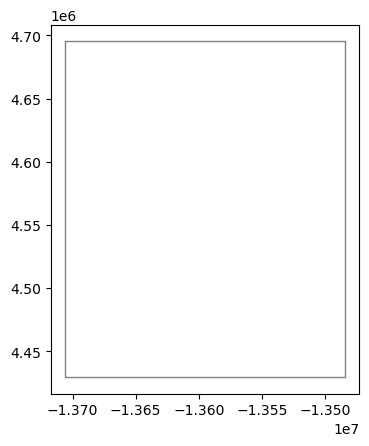

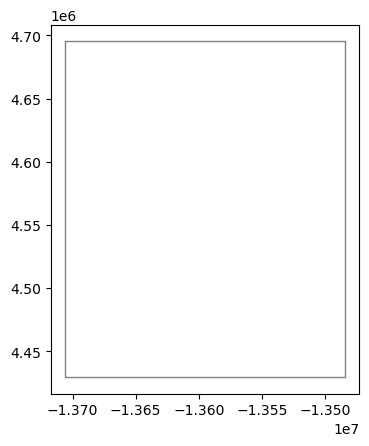

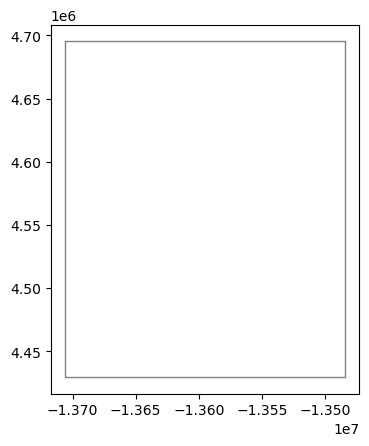

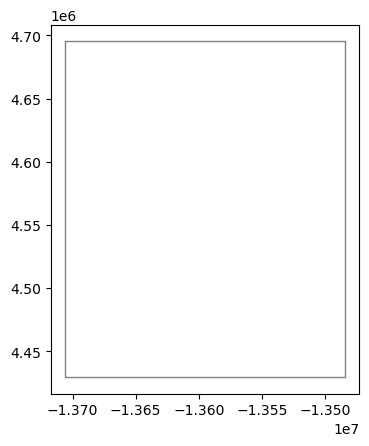

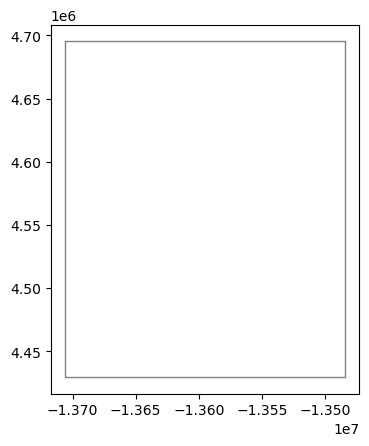

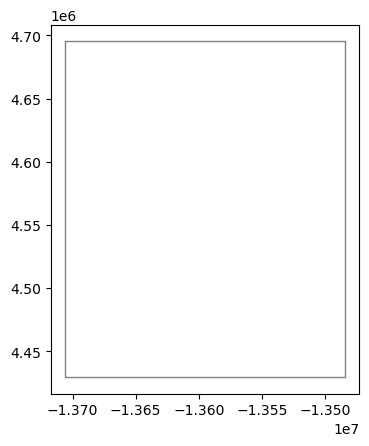

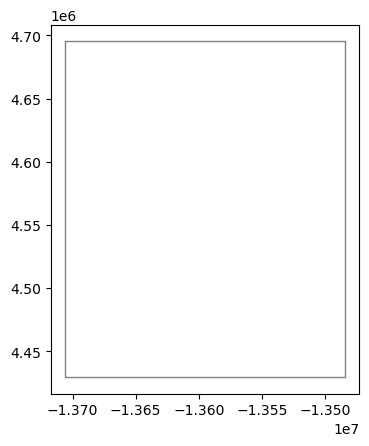

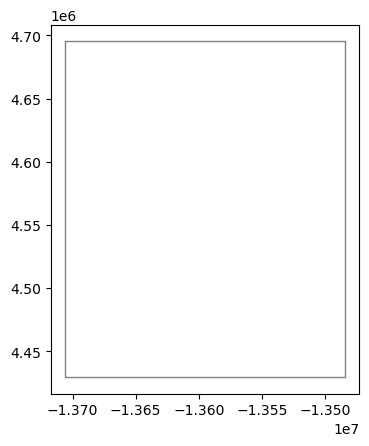

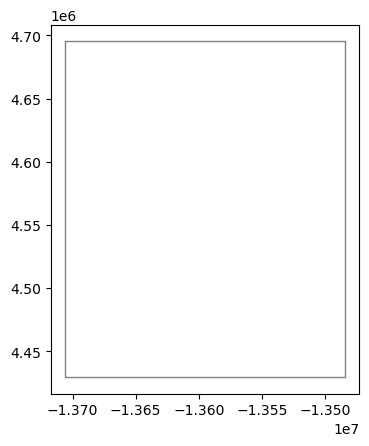

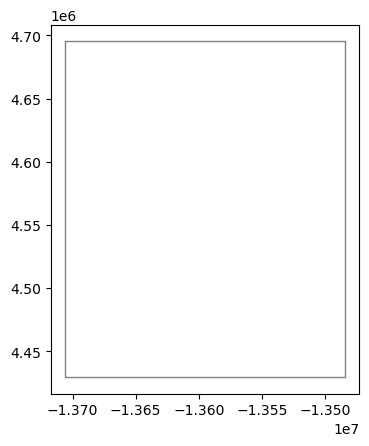

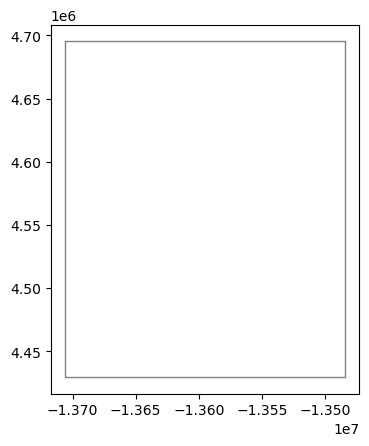

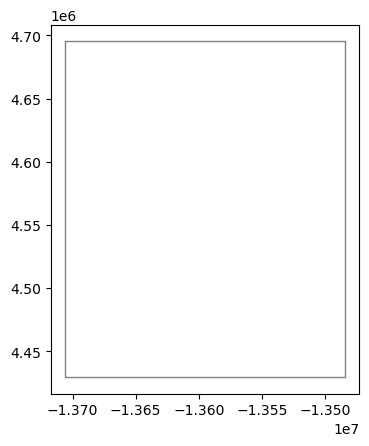

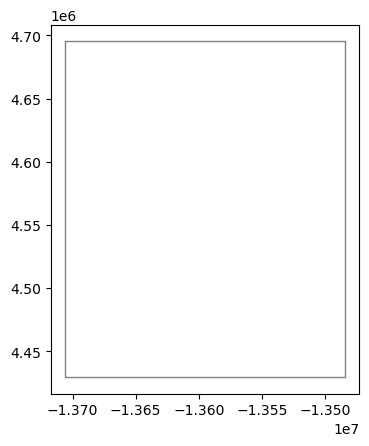

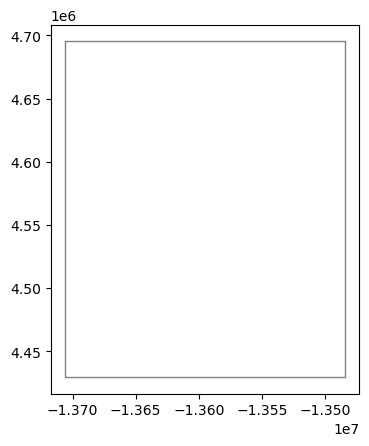

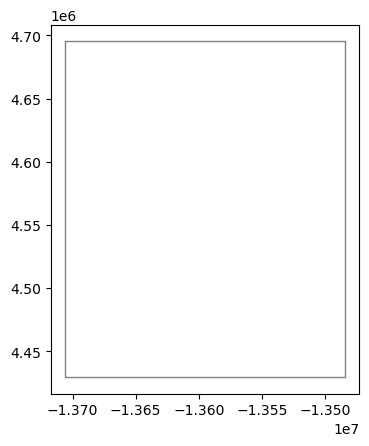

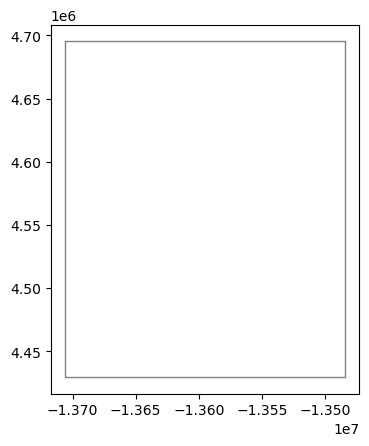

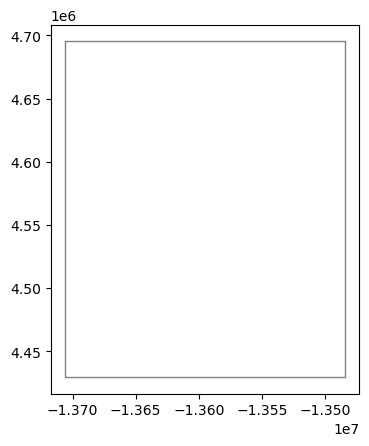

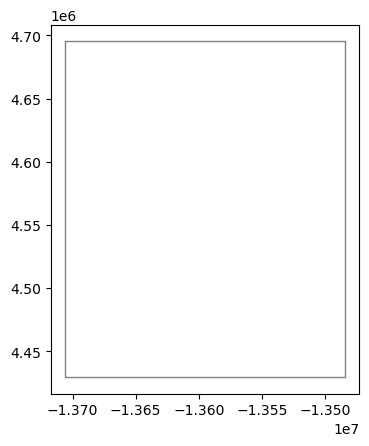

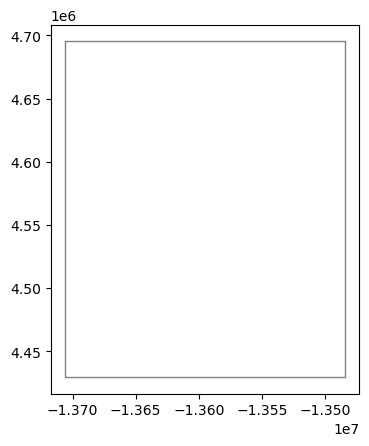

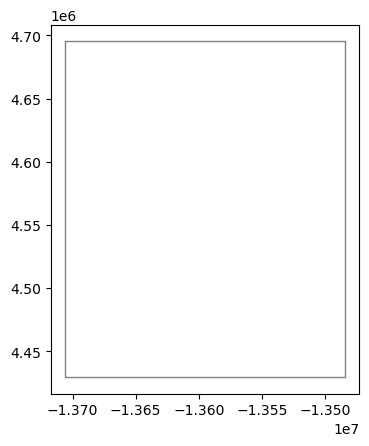

In [12]:
'''experiement'''
#not part of original 
from typing import Union
import geopandas as gpd
from shapely.geometry import Polygon
def points_to_bounding_box(points: Union[gpd.GeoSeries, gpd.GeoDataFrame]):
    """
    Function transform a set of points into a Polygon with bounding box.
    
    Parameters
    ----------
    points : gpd.GeoSeries
    
    Returns
    -------
    bounding_box : Polygon
    """
    bounds = points.total_bounds
    
    x_min, y_min, x_max, y_max = bounds
    
    polygon_tuples = [
        (x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)
    ]
    
    polygon = Polygon(polygon_tuples)
    return polygon

for x in FiresWithEuc:
    poly= points_to_bounding_box(FiresWithEuc)
    bb = gpd.GeoSeries(poly)
    bb.plot(color='white', edgecolor='gray')


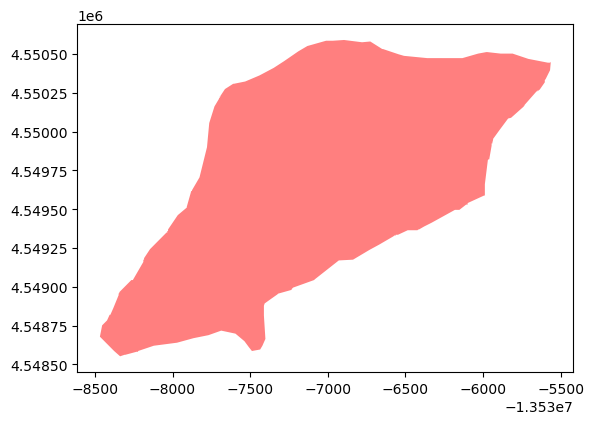

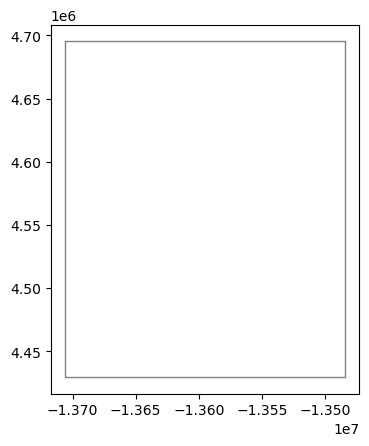

In [13]:
'''experiement'''
#not part of my code
# Make sure FireAreas and EucAreas match up
# Pulling out an individual fire and matching Euc
# However doing so changes the datatype to shapely polygon
# Turn it back into a pandas geodataframe in order to be plotted

fire_example =FiresWithEuc.iloc[9].geometry


# Create GeoDataFrames with a single row for visualization
gdf_fire_example = gpd.GeoDataFrame(geometry=[fire_example])

type(fire_example)

# First plot the fire area
ax = gdf_fire_example.plot(color='red', alpha=0.5, label='Fire Area')
bb.plot(color='white', edgecolor='gray')



bb = gpd.GeoSeries(poly)
#bb.set_crs(crs=FiresWithEuc)  # Here we must set CRS of our baseline set of points!
cent = bb.centroid  # We can generate centroid from GeoPandas GeoSeries object
# Plot



In [14]:
'''
success!
'''
# function that create a bb for each fire

def get_bbox(fire):
    '''
    This function returns a list containing the bbox for the geometry of each fire from the geometry column in a geodataframe
    args:
    fire : is a geodataframe that contains the geometry (polygon) for each fire
    
    '''
    fire_bounds = fire.bounds #find bounds for each fire geometry
    #print (fire_bounds)
    # creates new column named bbox and combines the columns minx, miny, maxx, maxy columns and separates them with , and add parenthesis
    #fire_bounds['bbox'] = fire_bounds.apply(lambda row: f"({row['minx']}, {row['miny']},{row['maxx']},{row['maxy']})", axis=1)
    fire_bounds['bbox'] = fire_bounds.apply(lambda row: (row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1)
    #print (fire_bounds['minx'])
    
    bbox = fire_bounds['bbox'] #creates dataframe with just coordinates of bbox as only column
    #bbox= list(bbox)  # turns bbox column into a list
    bbox= tuple(bbox)
    #print(bbox)
    return bbox

#convert to lat long here

In [15]:
boxs = get_bbox(FiresWithEuc)
source_crs = 'epsg:3857' # coord system used by fireswitheuc
target_crs = 'epsg:4326' # Global lat-lon coordinate system

latlon_to_s2_transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

projected_coordinates = []
for point in boxs:
    projected_minx, projected_miny = latlon_to_s2_transformer.transform(point[0], point[1])
    projected_maxx, projected_maxy = latlon_to_s2_transformer.transform(point[2], point[3])
    projected_coordinates.append((projected_minx, projected_miny, projected_maxx, projected_maxy))
    
projected_coordinates
#bbox= tuple(projected_coordinates)
len(FiresWithEuc)

33

In [21]:
 %%time 

def get_sat_images(bounds, dates, fires):
    '''
    This function gets image collections for each fire 
    
    bounds: list of bounding boxes 
    dates: a list of dates that include the start date and end date for the range in query of sat images
    fires: #FiresWithEuc
    
    This function is designed to be used with the outputs of the previous two functions:
    get_fire_dates(fdates_list) contains two lists- start date is first list, end date is second 
    get_bbox(FiresWithEuc) 
    '''

    start_dates, end_dates = dates #get_fire_dates(FiresWithEuc)
    boxs = bounds #get_bbox(FiresWithEuc)
    

    api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
    
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
    client = Client(cluster)
    client
    
    
    catalog = pystac_client.Client.open(api_url)
    
    
    ###################### transforms bbox from degrees to lat long
    source_crs = 'epsg:3857' # coord system used by fireswitheuc
    target_crs = 'epsg:4326' # Global lat-lon coordinate system
    
    #create the transfromer
    latlon_to_s2_transformer = pyproj.Transformer.from_crs(source_crs, target_crs)
    
    
    projected_coordinates = [] # empty list to store new coordinates
    
    for point in boxs:
        projected_minx, projected_miny = latlon_to_s2_transformer.transform(point[1], point[0])
        projected_maxx, projected_maxy = latlon_to_s2_transformer.transform(point[3], point[2])
        projected_coordinates.append((projected_minx, projected_miny, projected_maxx, projected_maxy))
    
    # to make sure that the new projected coords are tuples
    bbox_new = tuple(projected_coordinates)

    #################################
    
    img_collect = []
    for i in range(len(fires)):
        search = catalog.search(
            datetime=f"{start_dates[i]}/{end_dates[i]}", 
            collections=["landsat-c2-l2"],
            bbox=bbox_new[i],  
            query=["eo:cloud_cover<5"],
            max_items=1000
        )
        
        #print(search)
        items = pc.sign(search)
        img_collect.append(items)
        
        len(items)
        
    return img_collect 
        

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 19.1 µs


In [22]:
boundingboxes= get_bbox(FiresWithEuc)
fire_dates= get_fire_dates(FiresWithEuc)

get_sat_images(boundingboxes, fire_dates, FiresWithEuc)

------------------------------------------------------------

In [ ]:
# testing the workflow before putting it into my get_sat_images function

api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
    
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client
    
catalog = pystac_client.Client.open(api_url)
    
    #get_fire_dates(fdates_list) start date is first list end date is second 
    #get_bbox(FiresWithEuc)

start_dates, end_dates = get_fire_dates(FiresWithEuc) #function 1
#bbox = get_bbox(FiresWithEuc) #function 2
#######
boxs = get_bbox(FiresWithEuc)
source_crs = 'epsg:3857' # coord system used by fireswitheuc
target_crs = 'epsg:4326' # Global lat-lon coordinate system

latlon_to_s2_transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

projected_coordinates = []
for point in boxs:
    projected_minx, projected_miny = latlon_to_s2_transformer.transform(point[1], point[0])
    projected_maxx, projected_maxy = latlon_to_s2_transformer.transform(point[3], point[2])
    projected_coordinates.append((projected_minx, projected_miny, projected_maxx, projected_maxy))
#projected_coordinates
bbox_new = tuple(projected_coordinates)

#bbox_new[1]
############3

search = catalog.search(
datetime=f"{start_dates[1]}/{end_dates[1]}", 
collections=["landsat-c2-l2"],
bbox=bbox_new[1],  
query=["eo:cloud_cover<5"],
max_items=1000
)


In [ ]:
%%time
#print(search)
items = pc.sign(search)
len(items)

In [ ]:
print(items)